In [18]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, RepeatVector

In [19]:
FPT = pd.read_csv('/content/FPT.csv', sep=";")
FPT = FPT.dropna()  # Xóa các giá trị bị thiếu
FPT = FPT.reset_index(drop=True)  # Đặt lại chỉ mục

FPT

,Date,Price,High,Low
0,15/12/2016,15077.4,15167.5,15059.4
1,16/12/2016,15167.5,15167.5,15059.4
2,19/12/2016,15383.6,15383.6,15167.5
3,20/12/2016,15329.6,15455.7,15311.6
4,21/12/2016,15311.6,15401.7,15293.6
...,...,...,...,...
1745,11/12/2023,95000.0,95700.0,94600.0
1746,12/12/2023,96800.0,96800.0,95300.0
1747,13/12/2023,95200.0,97400.0,95200.0
1748,14/12/2023,96200.0,96400.0,95200.0


In [20]:
# Xử lý dữ liệu
prices = FPT['Price']

In [21]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

#7:3

In [22]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.7)
test_size = int(len(scaled_prices) * 0.3)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [23]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(FPT, time_steps):
    X, y = [], []
    for i in range(len(FPT) - time_steps):
        X.append(FPT[i:i+time_steps])
        y.append(FPT[i+time_steps])
    return np.array(X), np.array(y)


In [24]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [25]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [26]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
19/19 [==============================] - 3s 22ms/step - loss: 0.0191
Epoch 2/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0014
Epoch 3/100
19/19 [==============================] - 0s 22ms/step - loss: 2.9726e-04
Epoch 4/100
19/19 [==============================] - 1s 38ms/step - loss: 1.8216e-04
Epoch 5/100
19/19 [==============================] - 1s 49ms/step - loss: 1.2973e-04
Epoch 6/100
19/19 [==============================] - 1s 47ms/step - loss: 1.1781e-04
Epoch 7/100
19/19 [==============================] - 1s 44ms/step - loss: 1.1756e-04
Epoch 8/100
19/19 [==============================] - 1s 27ms/step - loss: 1.1631e-04
Epoch 9/100
19/19 [==============================] - 1s 40ms/step - loss: 1.2063e-04
Epoch 10/100
19/19 [==============================] - 1s 44ms/step - loss: 1.1341e-04
Epoch 11/100
19/19 [==============================] - 1s 39ms/step - loss: 1.1097e-04
Epoch 12/100
19/19 [==============================] - 1s 39ms/step - lo

In [28]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(FPT) + 1,len(FPT) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

16/16 [==============================] - 1s 9ms/step
[[1751]
 [1752]
 [1753]
 [1754]
 [1755]
 [1756]
 [1757]
 [1758]
 [1759]
 [1760]
 [1761]
 [1762]
 [1763]
 [1764]
 [1765]
 [1766]
 [1767]
 [1768]
 [1769]
 [1770]
 [1771]
 [1772]
 [1773]
 [1774]
 [1775]
 [1776]
 [1777]
 [1778]
 [1779]
 [1780]]
1/1 [==============================] - 0s 38ms/step
[85912.15  87195.77  87127.48  90408.21  90876.766 90237.8   90189.3
 91120.4   90999.25  91524.92  89947.14  89601.625 90491.336 91402.164
 89712.83  89982.57  89532.305 89790.96  90291.36  90497.92  90955.
 91991.81  93074.305 93375.    92896.56  92813.55  93438.27  94936.125
 93762.58  94585.16 ]


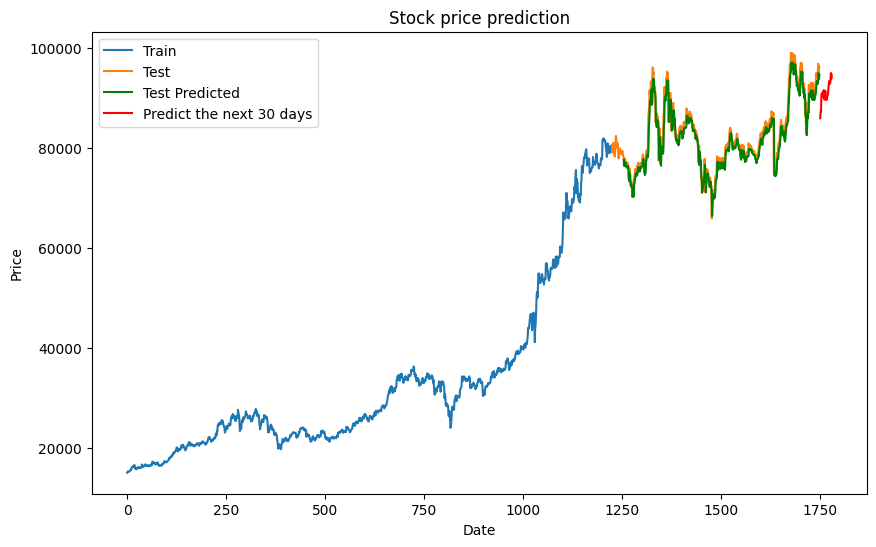

In [29]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict the next 30 days')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock price prediction')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

16/16 [==============================] - 0s 9ms/step


In [31]:
mape_test *= 100
print("RMSE:", round(rmse_test,3))
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))

RMSE: 1857.126
MAPE: 1.686
MAE: 1412.716


#8:2

In [32]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.8)
test_size = int(len(scaled_prices) * 0.2)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [33]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(FPT, time_steps):
    X, y = [], []
    for i in range(len(FPT) - time_steps):
        X.append(FPT[i:i+time_steps])
        y.append(FPT[i+time_steps])
    return np.array(X), np.array(y)

In [34]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [35]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [36]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
22/22 [==============================] - 4s 23ms/step - loss: 0.0375
Epoch 2/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0025
Epoch 3/100
22/22 [==============================] - 1s 34ms/step - loss: 4.2952e-04
Epoch 4/100
22/22 [==============================] - 1s 34ms/step - loss: 2.4906e-04
Epoch 5/100
22/22 [==============================] - 1s 32ms/step - loss: 2.4364e-04
Epoch 6/100
22/22 [==============================] - 1s 44ms/step - loss: 2.4129e-04
Epoch 7/100
22/22 [==============================] - 1s 44ms/step - loss: 2.4731e-04
Epoch 8/100
22/22 [==============================] - 1s 57ms/step - loss: 2.2984e-04
Epoch 9/100
22/22 [==============================] - 1s 55ms/step - loss: 2.2617e-04
Epoch 10/100
22/22 [==============================] - 1s 52ms/step - loss: 2.2467e-04
Epoch 11/100
22/22 [==============================] - 1s 29ms/step - loss: 2.1919e-04
Epoch 12/100
22/22 [==============================] - 1s 37ms/step - lo

In [38]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(FPT) + 1,len(FPT) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

10/10 [==============================] - 1s 10ms/step
[[1751]
 [1752]
 [1753]
 [1754]
 [1755]
 [1756]
 [1757]
 [1758]
 [1759]
 [1760]
 [1761]
 [1762]
 [1763]
 [1764]
 [1765]
 [1766]
 [1767]
 [1768]
 [1769]
 [1770]
 [1771]
 [1772]
 [1773]
 [1774]
 [1775]
 [1776]
 [1777]
 [1778]
 [1779]
 [1780]]
1/1 [==============================] - 1s 627ms/step
[87020.53  88602.555 88498.44  92203.17  92226.06  91640.28  91718.59
 92688.13  92480.78  93052.13  91376.5   91128.805 92045.266 92892.43
 91076.89  91511.13  90998.35  91273.195 91767.35  91947.305 92431.414
 93502.76  94585.09  94866.7   94397.3   94371.86  95021.79  96530.195
 95213.56  96200.34 ]


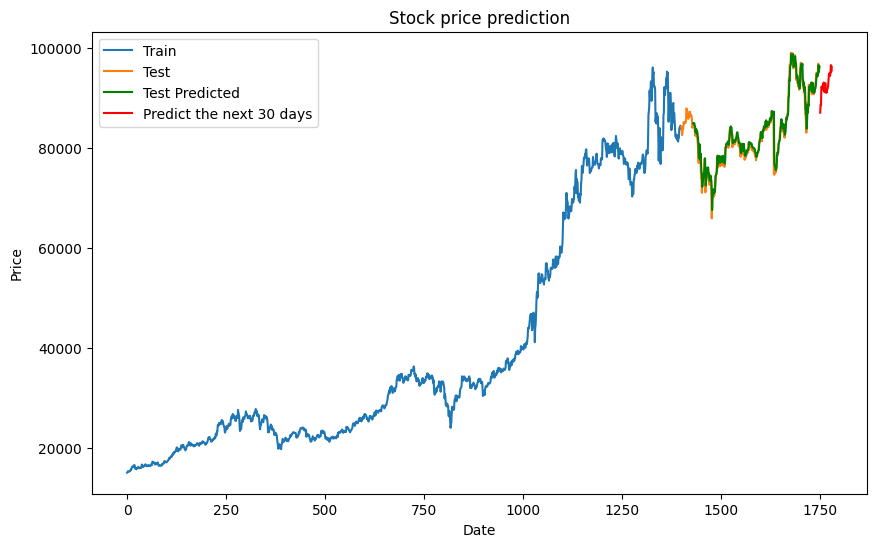

In [39]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict the next 30 days')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock price prediction')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

10/10 [==============================] - 0s 9ms/step


In [41]:
mape_test *= 100
print("RMSE:", round(rmse_test,3))
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))

RMSE: 1449.269
MAPE: 1.172
MAE: 957.447


# 9:1

In [43]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.9)
test_size = int(len(scaled_prices) * 0.1)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [44]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(FPT, time_steps):
    X, y = [], []
    for i in range(len(FPT) - time_steps):
        X.append(FPT[i:i+time_steps])
        y.append(FPT[i+time_steps])
    return np.array(X), np.array(y)

In [45]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [46]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [47]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [48]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
25/25 [==============================] - 4s 23ms/step - loss: 0.0377
Epoch 2/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0018
Epoch 3/100
25/25 [==============================] - 1s 23ms/step - loss: 3.6261e-04
Epoch 4/100
25/25 [==============================] - 1s 22ms/step - loss: 2.9682e-04
Epoch 5/100
25/25 [==============================] - 1s 22ms/step - loss: 2.7386e-04
Epoch 6/100
25/25 [==============================] - 1s 22ms/step - loss: 2.7546e-04
Epoch 7/100
25/25 [==============================] - 1s 23ms/step - loss: 2.6143e-04
Epoch 8/100
25/25 [==============================] - 1s 22ms/step - loss: 2.5934e-04
Epoch 9/100
25/25 [==============================] - 1s 23ms/step - loss: 2.5347e-04
Epoch 10/100
25/25 [==============================] - 1s 22ms/step - loss: 2.4966e-04
Epoch 11/100
25/25 [==============================] - 1s 34ms/step - loss: 2.5565e-04
Epoch 12/100
25/25 [==============================] - 1s 35ms/step - lo

In [49]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(FPT) + 1,len(FPT) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

5/5 [==============================] - 0s 6ms/step
[[1751]
 [1752]
 [1753]
 [1754]
 [1755]
 [1756]
 [1757]
 [1758]
 [1759]
 [1760]
 [1761]
 [1762]
 [1763]
 [1764]
 [1765]
 [1766]
 [1767]
 [1768]
 [1769]
 [1770]
 [1771]
 [1772]
 [1773]
 [1774]
 [1775]
 [1776]
 [1777]
 [1778]
 [1779]
 [1780]]
1/1 [==============================] - 0s 28ms/step
[86591.44  88015.9   88283.78  91903.2   92069.02  91017.15  91321.53
 92399.47  92153.26  92628.93  90956.61  90608.46  91788.2   92607.19
 90595.78  90987.766 90714.67  90845.25  91445.27  91569.23  92045.94
 93179.33  94279.75  94491.336 93942.23  93943.5   94692.    96247.66
 94799.625 95689.24 ]


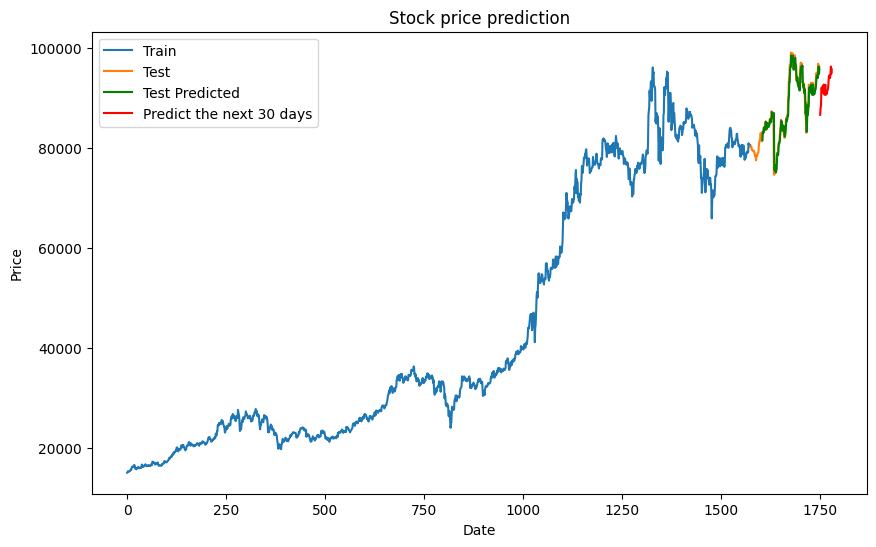

In [50]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict the next 30 days')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock price prediction')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

5/5 [==============================] - 0s 7ms/step


In [52]:
mape_test *= 100
print("RMSE:", round(rmse_test,3))
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))

RMSE: 1651.395
MAPE: 1.188
MAE: 1046.306
